In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} 

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 144328 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.22-0ubuntu1~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.22-0ubuntu1~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [2]:
!pip install treeinterpreter

In [3]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls 

adc.json  drive  sample_data


In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from scipy.stats import ks_2samp, chi2_contingency
from statsmodels.stats.proportion import proportions_ztest
from treeinterpreter import treeinterpreter as ti
import warnings
warnings.filterwarnings('ignore')

In [99]:
df_loan  = pd.read_csv('/content/drive/EY-AI/case_study/loan_grant_machine_learning/data/loan_table.csv')
df_borrower  = pd.read_csv('/content/drive/EY-AI/case_study/loan_grant_machine_learning/data/borrower_table.csv')
df_loan.shape, df_borrower.shape

((101100, 5), (101100, 12))

In [100]:
df_loan.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   loan_id       101100 non-null  int64  
 1   loan_purpose  101100 non-null  object 
 2   date          101100 non-null  object 
 3   loan_granted  101100 non-null  int64  
 4   loan_repaid   47654 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 3.9+ MB


In [101]:
df_borrower.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101100 entries, 0 to 101099
Data columns (total 12 columns):
 #   Column                                           Non-Null Count   Dtype  
---  ------                                           --------------   -----  
 0   loan_id                                          101100 non-null  int64  
 1   is_first_loan                                    101100 non-null  int64  
 2   fully_repaid_previous_loans                      46153 non-null   float64
 3   currently_repaying_other_loans                   46153 non-null   float64
 4   total_credit_card_limit                          101100 non-null  int64  
 5   avg_percentage_credit_card_limit_used_last_year  94128 non-null   float64
 6   saving_amount                                    101100 non-null  int64  
 7   checking_amount                                  101100 non-null  int64  
 8   is_employed                                      101100 non-null  int64  
 9   yearly_salary  

In [102]:
df_loan.head()

,loan_id,loan_purpose,date,loan_granted,loan_repaid
0,19454,investment,2012-03-15,0,NaN
1,496811,investment,2012-01-17,0,NaN
2,929493,other,2012-02-09,0,NaN
3,580653,other,2012-06-27,1,1.0
4,172419,business,2012-05-21,1,0.0


In [103]:
df_borrower.head()

,loan_id,is_first_loan,fully_repaid_previous_loans,currently_repaying_other_loans,total_credit_card_limit,avg_percentage_credit_card_limit_used_last_year,saving_amount,checking_amount,is_employed,yearly_salary,age,dependent_number
0,289774,1,NaN,NaN,8000,0.49,3285,1073,0,0,47,3
1,482590,0,1.0,0.0,4500,1.03,636,5299,1,13500,33,1
2,135565,1,NaN,NaN,6900,0.82,2085,3422,1,24500,38,8
3,207797,0,1.0,0.0,1200,0.82,358,3388,0,0,24,1
4,828078,0,0.0,0.0,6900,0.80,2138,4282,1,18100,36,1


In [0]:
# Merging using 'loan_id'
df = pd.merge(left=df_loan, right=df_borrower, how='left', on='loan_id')


df = df.drop(['loan_id','date'], axis=1)
rename = {
    'fully_repaid_previous_loans': 'previous_repaid', 
    'currently_repaying_other_loans': 'repaying',
    'total_credit_card_limit': 'credit_limit', 
    'avg_percentage_credit_card_limit_used_last_year': 'limit_used'
}
df = df.rename(columns = rename)

In [105]:
df.isnull().sum()

loan_purpose            0
loan_granted            0
loan_repaid         53446
is_first_loan           0
previous_repaid     54947
repaying            54947
credit_limit            0
limit_used           6972
saving_amount           0
checking_amount         0
is_employed             0
yearly_salary           0
age                     0
dependent_number        0
dtype: int64

In [106]:
sum(df.loan_granted == 0)

53446

In [107]:
sum(df.is_first_loan)

54947

In [0]:
# renaming dependent variable
df.previous_repaid.fillna(-1, inplace=True)
df.repaying.fillna(-1, inplace=True)
df.previous_repaid = df.previous_repaid.replace({0: 'No', 1: 'Yes', -1: 'NA'})
df.repaying = df.repaying.replace({0: 'No', 1: 'Yes', -1: 'NA'})

In [109]:
sum(df.credit_limit == 0)

6972

In [0]:
df.limit_used.fillna(0, inplace=True)

In [111]:
df[['saving_amount', 'checking_amount']].head()

,saving_amount,checking_amount
0,1491,6285
1,141,5793
2,660,3232
3,3345,2764
4,1050,3695


In [0]:
df['savings'] =  df.saving_amount + df.checking_amount
df = df.drop(['saving_amount', 'checking_amount'], axis=1)

# EDA

In [113]:
total = sum(df.loan_granted == 1)
df.loan_repaid.value_counts() / total

1.0    0.644353
0.0    0.355647
Name: loan_repaid, dtype: float64

In [114]:
df.describe()

,loan_granted,loan_repaid,is_first_loan,credit_limit,limit_used,is_employed,yearly_salary,age,dependent_number,savings
count,101100.000000,47654.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000,101100.000000
mean,0.471355,0.644353,0.543492,4112.743818,0.674202,0.658675,21020.727992,41.491632,3.864748,4976.768437
std,0.499181,0.478714,0.498107,2129.121462,0.256994,0.474157,18937.581415,12.825570,2.635491,2804.507542
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,17.000000
25%,0.000000,0.000000,0.000000,2700.000000,0.560000,0.000000,0.000000,32.000000,2.000000,2884.000000
50%,0.000000,1.000000,1.000000,4100.000000,0.710000,1.000000,21500.000000,41.000000,3.000000,4124.000000
75%,1.000000,1.000000,1.000000,5500.000000,0.850000,1.000000,35300.000000,50.000000,6.000000,6737.000000
max,1.000000,1.000000,1.000000,13500.000000,1.090000,1.000000,97200.000000,79.000000,8.000000,20558.000000


In [115]:
df.describe(include = ['O'])

,loan_purpose,previous_repaid,repaying
count,101100,101100,101100
unique,5,3,3
top,home,NA,NA
freq,24314,54947,54947


In [116]:
# Numerical features: Didn't repay v.s. Repaid (mean) 
df.groupby('loan_repaid').mean().drop(['loan_granted'], axis=1)

,is_first_loan,credit_limit,limit_used,is_employed,yearly_salary,age,dependent_number,savings
loan_repaid,,,,,,,,
0.0,0.532570,3459.352136,0.718196,0.791952,19893.114232,41.508320,4.233656,3095.128688
1.0,0.545919,5117.599166,0.669510,0.974891,34408.258972,41.533674,3.486843,6860.763857


In [117]:
# Categorical features: Didn't repay v.s. Repaid (mode) 
df.groupby('loan_repaid').agg(lambda x:x.value_counts().index[0])[['loan_purpose','previous_repaid','repaying']]

,loan_purpose,previous_repaid,repaying
loan_repaid,,,
0.0,emergency_funds,NA,NA
1.0,business,NA,NA


# Statistically significance
numerical variables - credit_limit, limit_used, yearly_salary, age, dependent_number and savings - Kolmogorov–Smirnov (K-S) tests.
is_first_loan and is_employed, the values are binary (0 or 1) - Z tests
categorical vaiables - loan_purpose, previous_repaid and repaying - chi-squared tests.

In [0]:
def run_test(feature):
    """ run either a K-S test, a Z test, or a chi-squred test """
    
    # split the borrowers into two groups based on whether they repaid
    group1 = df.loc[df.loan_repaid == 0, feature]
    group2 = df.loc[df.loan_repaid == 1, feature]

    # if the feature is categorical, do a chi-squred test
    if df[feature].dtype.name == 'object': 
        group1 = group1.value_counts().sort_index().tolist()
        group2 = group2.value_counts().sort_index().tolist()
        chi2, p_value, _, _ = chi2_contingency([group1, group2])
        print ("Chi-Sqaured test for " + feature +':')
        print ('test statistic = {}; p-value = {}'.format(chi2, p_value),'\n')
    # if the feature is numerical and is binary, do a Z test 
    elif len(df[feature].unique()) == 2:
        n1, p1 = len(group1), group1.sum()
        n2, p2 = len(group2), group2.sum()
        z_score, p_value = proportions_ztest([p1, p2], [n1, n2])
        print ("Z test for " + feature +':')
        print ('z-score = {}; p-value = {}'.format(z_score, p_value),'\n')
    # if the feature is numerical and is not binary, do a K-S test
    else:
        ks, p_value = ks_2samp(group1, group2)
        print ("K-S test for " + feature +':')
        print ('test statistic = {}; p-value = {}'.format(ks, p_value),'\n')

In [119]:
for feature in df.columns:
    if feature not in ['loan_repaid', 'loan_granted']: run_test(feature)

Chi-Sqaured test for loan_purpose:
test statistic = 1618.176084357717; p-value = 0.0 

Z test for is_first_loan:
z-score = -2.7995107289405037; p-value = 0.005118011571313927 

Chi-Sqaured test for previous_repaid:
test statistic = 40.79312315752653; p-value = 1.3863914026329079e-09 

Chi-Sqaured test for repaying:
test statistic = 5438.768331951727; p-value = 0.0 

K-S test for credit_limit:
test statistic = 0.35322588036422875; p-value = 0.0 

K-S test for limit_used:
test statistic = 0.15785510619177262; p-value = 8.731021956444561e-237 

Z test for is_employed:
z-score = -66.74437283169472; p-value = 0.0 

K-S test for yearly_salary:
test statistic = 0.37714850430190094; p-value = 0.0 

K-S test for age:
test statistic = 0.005253947381103519; p-value = 0.9237740167289575 

K-S test for dependent_number:
test statistic = 0.12093414392822227; p-value = 3.767898883432614e-139 

K-S test for savings:
test statistic = 0.7061041470431791; p-value = 0.0 



In [0]:
def DensityPlot(feature):
    fig = plt.figure(figsize=(8,4))
    sns.kdeplot(df.loc[df.loan_repaid == 0,feature], color='r', shade=True, label="didn't repay")
    sns.kdeplot(df.loc[df.loan_repaid == 1,feature], color='b', shade=True, label="repaid",)
    plt.xlabel(feature)
    plt.ylabel('kernel density')
    plt.show()

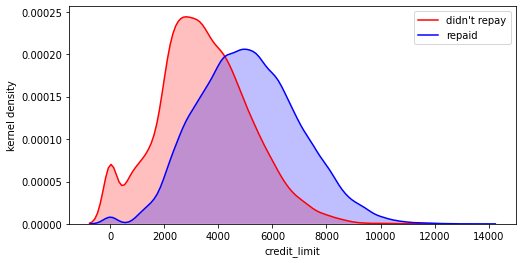

In [121]:

DensityPlot('credit_limit')

In [0]:

def BarPlot(feature):
    counts = (
        df.groupby('loan_repaid')[feature]
        .value_counts(normalize=True)
        .rename('fraction')
        .reset_index()
    )
    fig = plt.figure()
    sns.barplot(x=feature, y='fraction', hue='loan_repaid', data=counts)
    plt.ylabel('fraction')
    plt.show()

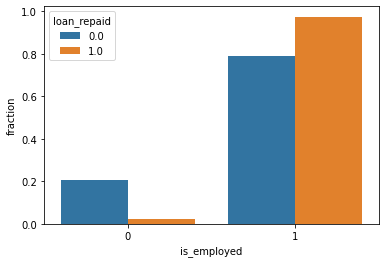

In [123]:

BarPlot('is_employed')

In [124]:


corr = df.drop(['loan_granted'],axis=1).corr()
corr

,loan_repaid,is_first_loan,credit_limit,limit_used,is_employed,yearly_salary,age,dependent_number,savings
loan_repaid,1.000000,0.012824,0.401911,-0.116388,0.305749,0.426648,0.000947,-0.136384,0.621702
is_first_loan,0.012824,1.000000,0.000679,-0.002585,-0.000971,-0.001674,-0.002353,0.000887,0.006550
credit_limit,0.401911,0.000679,1.000000,0.318143,0.195274,0.222497,-0.004052,-0.058650,0.292580
limit_used,-0.116388,-0.002585,0.318143,1.000000,-0.009516,-0.011848,-0.002836,0.005154,-0.009701
is_employed,0.305749,-0.000971,0.195274,-0.009516,1.000000,0.799051,0.005059,-0.060847,0.302263
yearly_salary,0.426648,-0.001674,0.222497,-0.011848,0.799051,1.000000,0.005412,-0.073218,0.350416
age,0.000947,-0.002353,-0.004052,-0.002836,0.005059,0.005412,1.000000,0.000862,-0.002399
dependent_number,-0.136384,0.000887,-0.058650,0.005154,-0.060847,-0.073218,0.000862,1.000000,-0.097528
savings,0.621702,0.006550,0.292580,-0.009701,0.302263,0.350416,-0.002399,-0.097528,1.000000


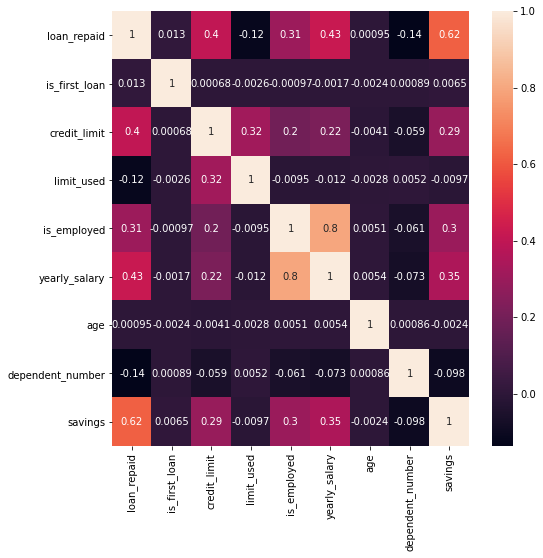

In [125]:
plt.figure(figsize=(8,8))
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True)
plt.show()

In [0]:

# Perform one-hot encoding
df_onehot = pd.get_dummies(df, columns=['loan_purpose','previous_repaid','repaying'])

# Drop one dummy variable for each of the three features to avoid dummy variable trap
df_onehot = df_onehot.drop(['loan_purpose_other','previous_repaid_NA','repaying_NA'], axis=1)

In [0]:
df_onehot = df_onehot.drop(['is_first_loan', 'age', 'is_employed'],axis=1)

In [0]:
le = LabelEncoder()
df_label = df.copy()

for x in df_label.columns:    
    if df_label[x].dtype.name == 'object':
        df_label.loc[:, x] = le.fit_transform(df_label.loc[:, x])

df_label = df_label.drop(['is_first_loan', 'age', 'is_employed'],axis=1)

In [0]:
# Those people that were not granted loans
X_declined_onehot = df_onehot[df.loan_granted == 0].reset_index(drop=True).drop(['loan_granted','loan_repaid'],axis=1)
X_declined_label = df_label[df.loan_granted == 0].reset_index(drop=True).drop(['loan_granted','loan_repaid'],axis=1)

# Those that were granted loans
X_onehot = df_onehot[df.loan_granted == 1].reset_index(drop=True).drop(['loan_granted','loan_repaid'],axis=1)
X_label = df_label[df.loan_granted == 1].reset_index(drop=True).drop(['loan_granted','loan_repaid'],axis=1)

# target variable
Y = df[df.loan_granted == 1].reset_index(drop=True)['loan_repaid'].values

# Train/Test split
X_train_onehot, X_test_onehot, Y_train, Y_test =  train_test_split(X_onehot, Y, test_size=0.3, random_state=0)
X_train_label, X_test_label, _, _ =  train_test_split(X_label, Y, test_size=0.3, random_state=0)

In [0]:
scaler = StandardScaler()

# Random Forest 


In [131]:
rf = RandomForestClassifier(n_estimators=50, random_state=0)

# Specify parameters and distributions to sample from
parameters = {
    "max_features": [2,3,4,5],
    "min_samples_split": [2,3,4,5],
    "max_depth": range(8, 13)
}

# Run Grid Search
grid_search = GridSearchCV(estimator = rf,
                           param_grid = parameters,
                           scoring ='roc_auc',
                           n_jobs = -1)

grid_search = grid_search.fit(X_train_label, Y_train)

print (grid_search.best_score_)
print (grid_search.best_params_)
rf = (grid_search.best_estimator_)

0.9658485997066777
{'max_depth': 11, 'max_features': 3, 'min_samples_split': 5}


In [132]:
evaluation(rf, X_train_label, X_test_label)

--- ROC AUC ---
Training Set: 0.9837269497729559
Test Set: 0.9649825090809265

--- Accuracy ---
Training Set: 0.9310189765266661
Test Set: 0.901447856193607

--- Confusion Matrix ---
True Positive: 8437
False Negative: 849
True Negative: 4451
False Positive: 560

--- Precision ---
Training Set: 0.9592160253638853
Test Set: 0.9377570301211515

--- Recall ---
Training Set: 0.9322128851540616
Test Set: 0.9085720439371097

--- F1 Score ---
Training Set: 0.9455216989843029
Test Set: 0.922933872996773


No handles with labels found to put in legend.


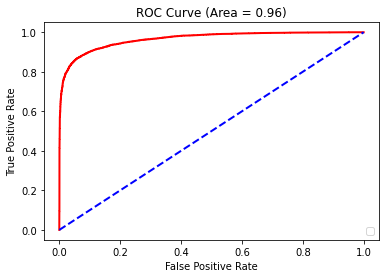

In [133]:
plot_ROC(rf, X_test_label)

In [134]:
# bank
score_bank = sum(Y_test == 1) - sum(Y_test == 0)

# my Logistic regression model
tn, fp, fn, tp = confusion_matrix(Y_test, rf.predict(X_test_label)).ravel()
score_rf = tp - fp

print ("The bank scores {} points".format(score_bank))
print ("The Random Forest classifier scores {} points".format(score_rf))

The bank scores 4275 points
The Random Forest classifier scores 7877 points


In [135]:
# Calculate the fraction of people who would have been granted 
# loans based on my model among those customers who were not 
# granted loans

Y_declined_pred = rf.predict(X_declined_label)
print (Y_declined_pred.sum()/len(Y_declined_pred))

0.34354301538000975


In [136]:
tp_pred = int(round(Y_declined_pred.sum()*tp*1./(tp + fp)))
fp_pred = int(round(Y_declined_pred.sum()*fp*1./(tp + fp)))
print ("Predicted true positive: ", tp_pred)
print ("Predicted false positive: ", fp_pred)
print ("The estimated profitability: {} points".format(tp_pred - fp_pred))

Predicted true positive:  17218
Predicted false positive:  1143
The estimated profitability: 16075 points


In [137]:
imp = pd.DataFrame(rf.feature_importances_, columns = ['Importance'], index = X_label.columns)
imp = imp.sort_values(['Importance'], ascending = False)
imp

,Importance
savings,0.595041
yearly_salary,0.171987
credit_limit,0.123973
repaying,0.046407
limit_used,0.032967
dependent_number,0.012717
loan_purpose,0.010013
previous_repaid,0.006895


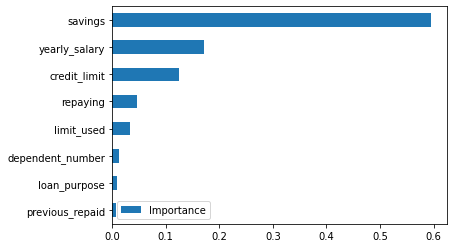

In [138]:
#imp.plot.barh()
ax = imp.plot.barh()  # or df.plot(), or similar
ax.invert_yaxis()

In [139]:
instances = X_test_label.iloc[:3, :]

# see the links above for "treeinterpreter" 
prediction, bias, contribution = ti.predict(rf, instances)

for i in range(len(instances)):
    print ("Instance", i)
    print ("Prediction: ", round(prediction[i,1],3))
    print ("Bias (training set mean value): ", round(bias[i,1],3))
    print ("Feature contributions:")
    
    # The feature contributions are sorted by their absolute impact
    for c,feature in sorted(zip(contribution[i,:,1], X_label.columns.values), 
                             key=lambda x: -abs(x[0])):
        print (feature, round(c, 3))
    print ("-" * 40 )

Instance 0
Prediction:  0.043
Bias (training set mean value):  0.642
Feature contributions:
savings -0.303
yearly_salary -0.175
credit_limit -0.13
limit_used -0.047
loan_purpose 0.043
repaying 0.028
previous_repaid -0.008
dependent_number -0.006
----------------------------------------
Instance 1
Prediction:  0.933
Bias (training set mean value):  0.642
Feature contributions:
savings 0.394
repaying -0.112
yearly_salary 0.074
credit_limit -0.047
limit_used -0.023
loan_purpose 0.007
dependent_number -0.002
previous_repaid 0.001
----------------------------------------
Instance 2
Prediction:  0.026
Bias (training set mean value):  0.642
Feature contributions:
savings -0.326
yearly_salary -0.207
credit_limit -0.054
limit_used -0.045
repaying 0.031
previous_repaid -0.015
loan_purpose -0.006
dependent_number 0.005
----------------------------------------


# Analysis

**Using correlation heatmap**

* The features that correlate with loan_repaid most are savings, yearly_salary, credit_limit, and is_employed.
* age and is_first_loan do not correlate with other features.
*  yearly_salary and is_employed highly correlate with each other. Keeping yearly_salary is probably enough.


**Checking feature importance at every instance of RF using treeinterpreter**
https://github.com/andosa/treeinterpreter 

* instance 0: savings, yearly_salary, credit_limit and limit_used are the most 
dominant factors that result in the rejection.
* instance 1: savings and yearly_salary are the most dominant factors that result in the approval.
* instance 2: same as instance 0




